In [ ]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt


In [ ]:
 # !unzip  elephants_archive.zip

In [ ]:
!ls dataset

test  train


In [ ]:
!ls dataset/train

African  Asian


### Filtering out corrupted images

In [ ]:
#num_skipped = 0
#for folder_name in ("African", "Asian"):
#   folder_path = os.path.join("dataset/train", folder_name)
#    for fname in os.listdir(folder_path):
#       fpath = os.path.join(folder_path, fname)
#       try:
#           fobj = open(fpath, "rb")
#           is_jfif = b"JFIF" in fobj.peek(10)
#       finally:
#           fobj.close()

#       if not is_jfif:
#           num_skipped += 1
            # Delete corrupted image
#           os.remove(fpath)

#print(f"Deleted {num_skipped} images."#)

Deleted 6 images.


# Generating a Dataset

In [ ]:
image_size = (150, 150)
batch_size = 10
train_ds, val_ds  = keras.utils.image_dataset_from_directory(
    "dataset/train",
    validation_split= 0.2,
    subset="both",
    seed = 500,
    image_size= image_size,
    batch_size= batch_size
)

Found 834 files belonging to 2 classes.
Using 668 files for training.
Using 166 files for validation.


# Visualizing the data

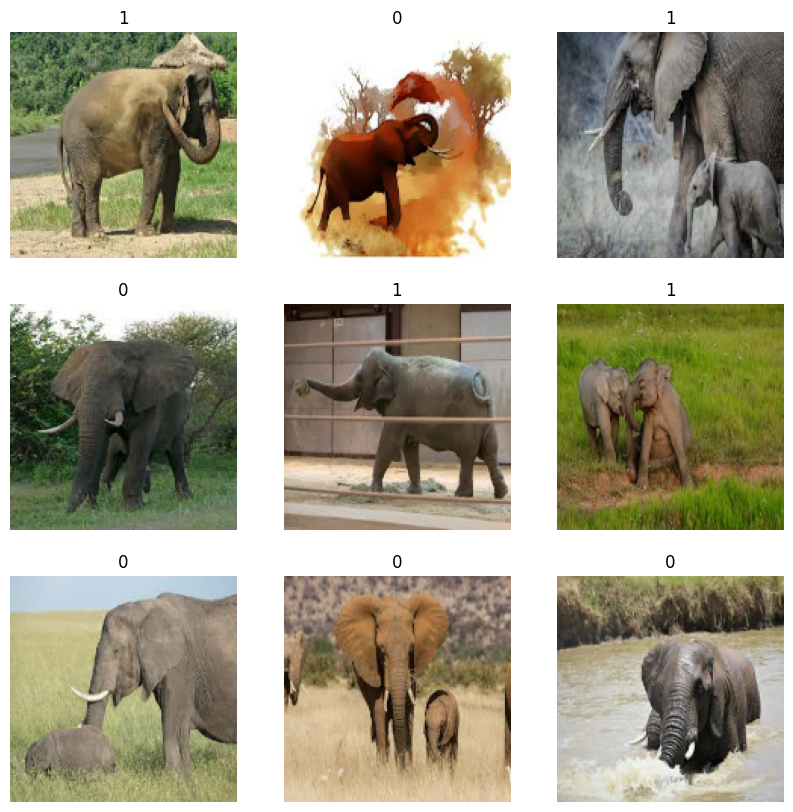

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

# Using image data augmentaton

In [ ]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

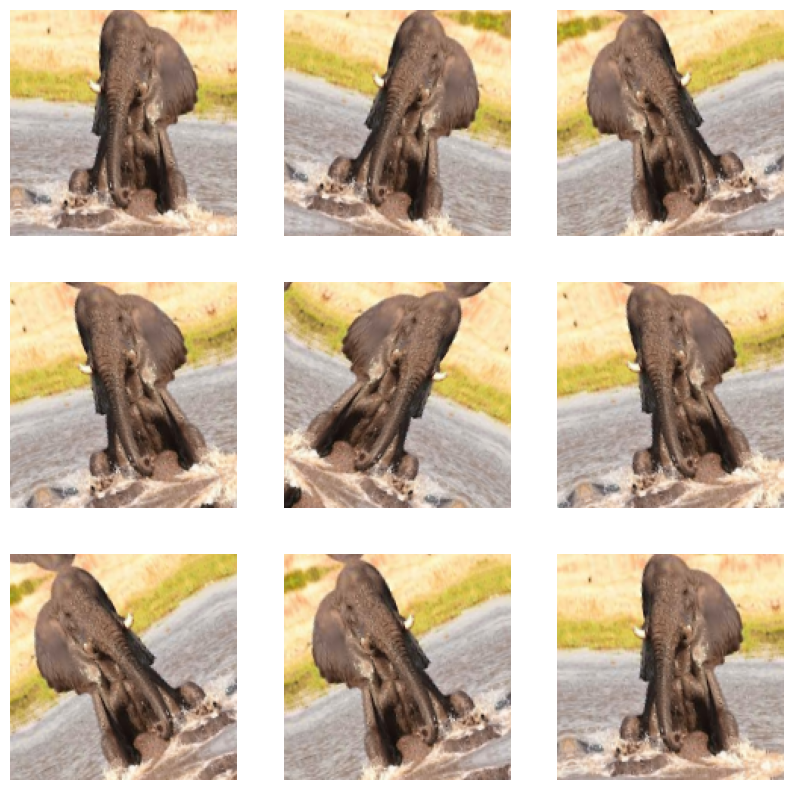

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [ ]:
## Applying 'data augmentation to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

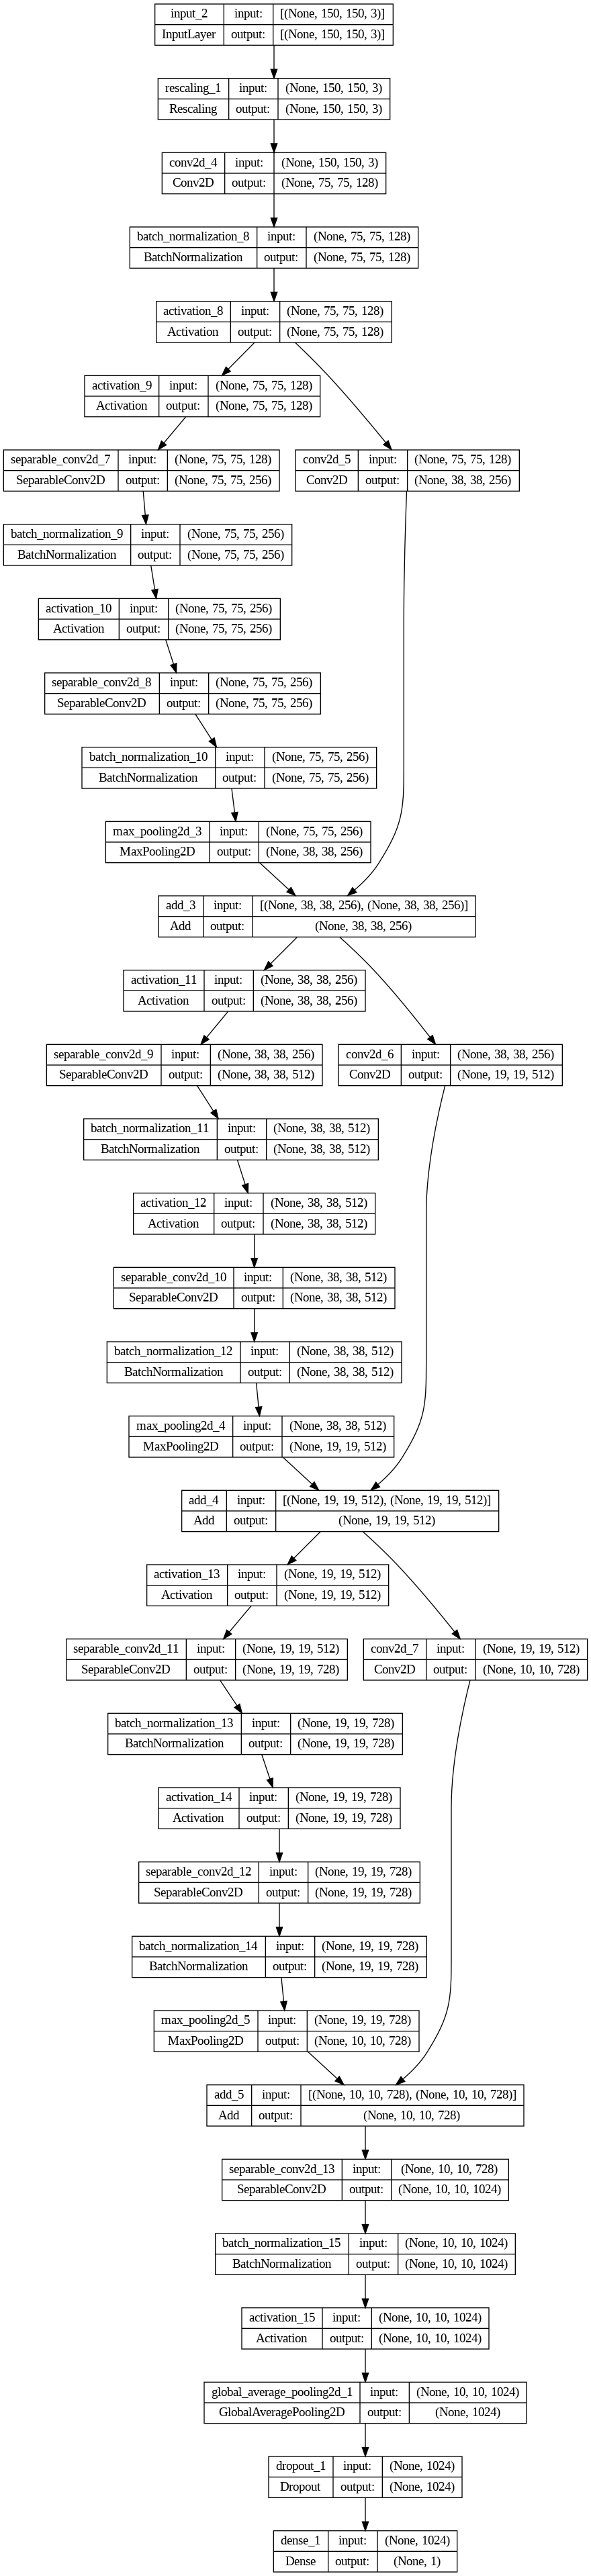

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
#keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 8

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.legacy.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/8
67/67 [==============================] - 278s 4s/step - loss: 0.7584 - acc: 0.5479 - val_loss: 0.7134 - val_acc: 0.3976
Epoch 2/8
67/67 [==============================] - 263s 4s/step - loss: 0.6972 - acc: 0.5749 - val_loss: 0.7399 - val_acc: 0.3976
Epoch 3/8
67/67 [==============================] - 258s 4s/step - loss: 0.6717 - acc: 0.6048 - val_loss: 0.7646 - val_acc: 0.3976
Epoch 4/8
67/67 [==============================] - 258s 4s/step - loss: 0.6685 - acc: 0.5734 - val_loss: 0.8388 - val_acc: 0.3976
Epoch 5/8
67/67 [==============================] - 258s 4s/step - loss: 0.6494 - acc: 0.6228 - val_loss: 0.9416 - val_acc: 0.3976
Epoch 6/8
67/67 [==============================] - 257s 4s/step - loss: 0.6403 - acc: 0.6108 - val_loss: 0.9717 - val_acc: 0.3976
Epoch 7/8
67/67 [==============================] - 260s 4s/step - loss: 0.6279 - acc: 0.6347 - val_loss: 0.9843 - val_acc: 0.3976
Epoch 8/8
67/67 [==============================] - 260s 4s/step - loss: 0.6062 - acc: 0.64

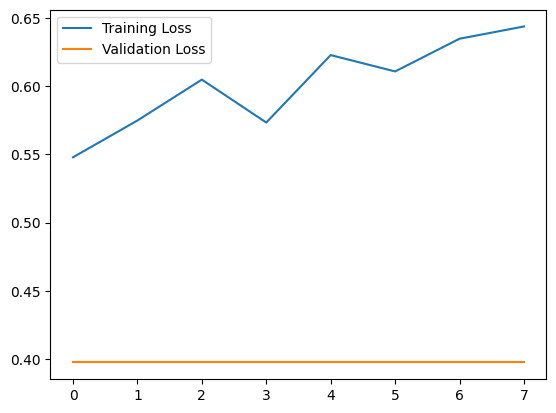

In [ ]:
plt.plot(range(len(history.history["acc"])),history.history["acc"],label="Training Loss")
plt.plot(range(len(history.history["val_acc"])),history.history["val_acc"],label="Validation Loss")
plt.legend()

In [ ]:
def make_transfer_model(input_shape, num_classes):
    # Load the pre-trained weights of MobileNetV2 and freeze the weights
    backbone = keras.applications.MobileNetV2(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape,
    )
    backbone.trainable = False

    inputs = layers.Input(input_shape)
    x = keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = backbone(x)
    x = layers.Dropout(0.3)(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)

    return keras.Model(inputs, outputs, name="keypoint_detector")

In [ ]:
model2 = make_transfer_model(input_shape=image_size + (3,), num_classes=2)

In [ ]:
epochs = 8

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model2.compile(
    optimizer=keras.optimizers.legacy.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

history = model2.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/8
67/67 [==============================] - 22s 240ms/step - loss: 0.9112 - acc: 0.4820 - val_loss: 0.8340 - val_acc: 0.4096
Epoch 2/8
67/67 [==============================] - 17s 245ms/step - loss: 0.8453 - acc: 0.5030 - val_loss: 0.7956 - val_acc: 0.4518
Epoch 3/8
67/67 [==============================] - 15s 230ms/step - loss: 0.7974 - acc: 0.5599 - val_loss: 0.7171 - val_acc: 0.5181
Epoch 4/8
67/67 [==============================] - 15s 223ms/step - loss: 0.7430 - acc: 0.5763 - val_loss: 0.7172 - val_acc: 0.5241
Epoch 5/8
67/67 [==============================] - 16s 243ms/step - loss: 0.7129 - acc: 0.6243 - val_loss: 0.7124 - val_acc: 0.5301
Epoch 6/8
67/67 [==============================] - 16s 231ms/step - loss: 0.6822 - acc: 0.6138 - val_loss: 0.6671 - val_acc: 0.5723
Epoch 7/8
67/67 [==============================] - 15s 222ms/step - loss: 0.6567 - acc: 0.6617 - val_loss: 0.7489 - val_acc: 0.5120
Epoch 8/8
67/67 [==============================] - 15s 229ms/step - loss: 0.

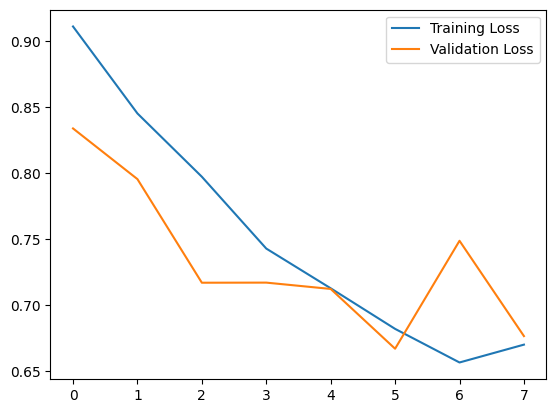

In [ ]:
plt.plot(range(len(history.history["loss"])),history.history["loss"],label="Training Loss")
plt.plot(range(len(history.history["val_loss"])),history.history["val_loss"],label="Validation Loss")
plt.legend()

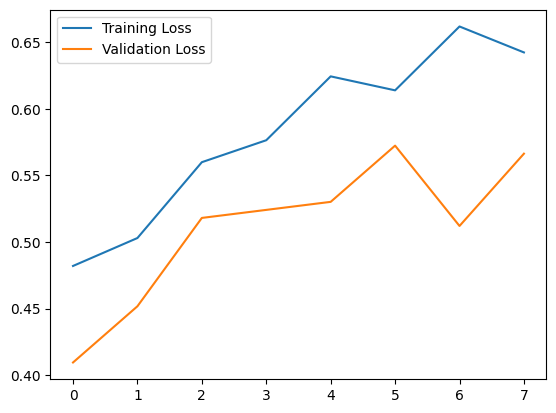

In [ ]:
plt.plot(range(len(history.history["acc"])),history.history["acc"],label="Training Loss")
plt.plot(range(len(history.history["val_acc"])),history.history["val_acc"],label="Validation Loss")
plt.legend()